# MIT-GSL Uruguay 

## January 2020

-----

# Lesson - 1: Introduction to ML

** The first set of hands-on sessions are meant to provide a general overview of ML with the following topcs: **
1. Data import and export
2. Data pre-processing
3. Text pre-processing
4. Feature engineering
5. Cross-validation
5. High-dimensional modeling
6. Dimension reduction
6. Classification models:
    1. Logistic regression
    2. Regularized regression
    3. SVM
    4. Random Forests
    5. Boosted Trees
7. Model evaluation
8. Ensembling

** The class is desgined to be interactive. All the code and required data are provided. **

-----

Kaggle StumbleUpon Competition
==================
https://www.kaggle.com/c/stumbleupon

** About StumbleUpon **: User-curated web content discovery engine that recommends relevant, high quality pages and media to its users, based on their interests.

** Competition **: 
1. Some pages, such as news articles or seasonal recipes, are only relevant for a short period of time, others maintain a timeless quality and can be recommended to users long after they are discovered. 
2. Goal is to identify pages which are ephemeral and which are evergreen

** Objective **: Build classifier(s) to categorize webpages as evergreen (1) or non-evergreen (0)

** Evaluation **: Area under the curve (AUC)

** Data **: 
* Tab-separated file containing meta-data, webpage text (boilerplate), evergreen classification (target)
* Text based: high-dimensional
* Small sample size: prone to overfitting, high variance in results
    
** Notes **:
* We are only using the *train* data from the competition
* We will create our own split of training-val-test data
 


-----

Import Python Modules 
=================

In [262]:
# ==============================================
# 0. Module imports
# ==============================================

# this will make joblib work
import sys; sys.path.append('/Users/julianalverio/code/conda/envs/sac/lib/python3.6/site-packages/')

# data manipulation
import pandas as pd
import numpy as np
import scipy.stats as st

# plots
%matplotlib inline
import random
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl

# classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# dimension reduction
from sklearn.decomposition import PCA

# cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection

# parallel processing
from joblib import Parallel, delayed  
import multiprocessing

# model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

# text mining
import re
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")

import os
os.chdir(os.path.join("..", "data"))

# 1. Data Import and Explore

In [2]:
data = pd.read_table("stumbleupon/train.tsv", sep= "\t")

## Variable descriptions:

1. **url**: Url of the webpage to be classified
2. **urlid**: StumbleUpon's unique identifier for each url
3. **boilerplate**: Boilerplate text
4. **alchemy_category**:	Alchemy category
5. **alchemy_category_score**:	Alchemy category score
6. **avglinksize**:	Average number of words in each link
7. **commonLinkRatio_1**:	# of links sharing at least 1 word with 1 other links / # of links
8. **commonLinkRatio_2**:	# of links sharing at least 1 word with 2 other links / # of links
9. **commonLinkRatio_3**:	# of links sharing at least 1 word with 3 other links / # of links
10. **commonLinkRatio_4**:	# of links sharing at least 1 word with 4 other links / # of links
11. **compression_ratio**:	Compression achieved on this page via gzip (measure of redundancy)
12. **embed_ratio**: Count of number of "embed" usage
13. **frameBased**: A page is frame-based (1) if it has no body markup but have a frameset markup
14. **frameTagRatio**: Ratio of iframe markups over total number of markups
15. **hasDomainLink**:	True (1) if it contains an "a" with an url with domain
16. **html_ratio**:	Ratio of tags vs text in the page
17. **image_ratio**: Ratio of "img" tags vs text in the page
18. **is_news**: True (1) if StumbleUpon's news classifier determines that this webpage is news
19. **lengthyLinkDomain**: True (1) if at least 3 "a"'s text contains more than 30 alphanumeric characters
20. **linkwordscore**: Percentage of words on the page that are in hyperlink's text
21. **news_front_page**: True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
22. **non_markup_alphanum_characters**:	integer	Page's text's number of alphanumeric characters
23. **numberOfLinks**: Number of "a"  markups
24. **numwords_in_url**: Number of words in url
25. **parametrizedLinkRatio**: A link is parametrized if it's url contains parameters  or has an attached onClick event
26. **spelling_errors_ratio**: Ratio of words not found in wiki (considered to be a spelling mistake)
27. **label**: User-determined label. Either evergreen (1) or non-evergreen (0)


## Visualization

In [281]:
'''
SHIT
url -- object type, the literal url
urlid -- uid for the url, drop it
avglinksize -- huge spread, mostly around 1 or two. This would need to be hella binned carefully. I think useless from Madhav's results
frameBased -- 0 everywhere, garbage
is_news -- 1 everywhere

TEXT
boilerplate -- text feature

NUMERICAL
alchemy_category -- business, health, sports, etc.
alchemy_category_score -- 0 to 1 STRING with LOTS of '?' values
commonlinkratio -- cont value from 0 to 1 that works nicely, needs binning. Nice gaussian on 1, moves to left with increasing idx
compression_ratio -- continuous value with huge bimodal spread -- needs to be binned carefully
embed_ratio -- perfect bimodal spread -- two humps. -1 and 0.25
frameTagRatio -- 0 to 0.44 cont, spread leans left -- it is half a gaussian
hasDomainLink -- 0/1 categorical, almost all 0
html_ratio -- cont 0 to 0.7, gaussian spread
image_ratio -- spread -1 to 113, but almost exclusively right at 0
lengthy-link domain -- categorical 0/1, good spread
linkwordscore -- 0 to 100 good spread
news_front_page -- STRING, ? values, 0-1 categorical, almost all 0
non_markup_alphnum_characters -- huge spread, highly concentrated near 0
numberoflinks -- huge spread, mostly close to 0
numwordsinurl -- good spread, 0 to 25, has a long upper tail
Parametrizedlinkratio -- 0 to 1 continuous, skewed toward 0 -- right half of gaussian
spelling_errors_ratio -- 0 to 1, heavy leaning to 0


EVAN

[(-0.0017029098026004608, 'avglinksize'),
 (-0.0015477640384510272, 'image_ratio'),
 (-0.0013366491854696072, 'numberOfLinks'),
 (-0.0012422148274934264, 'urlid'),
 (-0.0012276386004722584, 'non_markup_alphanum_characters'),
 (-0.0003632131231506852, 'hasDomainLink'),
 (-1.6445368175466157e-05, 'compression_ratio'),
 (0, 'alchemy_category_score'),
 (0, 'boilerplate'),
 (0, 'commonLinkRatio_1'),
 (0, 'commonLinkRatio_2'),
 (0, 'commonLinkRatio_3'),
 (0, 'commonLinkRatio_4'),
 (0, 'frameBased'),
 (0, 'is_news'),
 (0, 'label'),
 (0, 'news_front_page'),
 (0, 'url'),
 (0.00016331922818457745, 'lengthyLinkDomain'),
 (0.0007063846400122697, 'html_ratio'),
 (0.0011190978216005787, 'embed_ratio'),
 (0.0020862547468744053, 'spelling_errors_ratio'),
 (0.002983052198938685, 'parametrizedLinkRatio'),
 (0.004883582510772921, 'numwords_in_url'),
 (0.016376170421172676, 'linkwordscore'),
 (0.016942353001673127, 'frameTagRatio'),
 (0.040352206434091764, 'alchemy_category')]



'''

# Alchemy category, converting to one-hots
df = data['alchemy_category']   # 2K ? values
one_hots = pd.get_dummies(data['alchemy_category'])
df = one_hots
rename_dict = {'?': 'alchemy_cat_?'}
df = df.rename(columns=rename_dict)

# FrameTagRatio, leaving as continuous number
df_var = data['frameTagRatio']
df['frame_tag_ratio'] = df_var



# link word score, 0-100 gaussian, keeping continuous
df['link_word_score'] = data['linkwordscore']


# alchemy category score, with replacing missing values with random
df_var = data['alchemy_category_score']
df_var_temp = df_var.apply(lambda x: np.random.random() if x == '?' else float(x)).astype('float32')
df['alchemy_category_score'] = df_var_temp


# num word in url -- discrete 0-25 to custom binning from looking at the histogram
df_var = data['numwords_in_url']
bins = [0, 6, 8, 13, 25]
df_var_temp = pd.cut(x=df_var, bins=bins, right=True, labels=['num_words_url_bin_0', 'num_words_url_bin_1', 'num_words_url_bin_2', 'num_words_url_bin_3'])
dummies = pd.get_dummies(df_var_temp)
df = pd.concat([df, dummies], axis=1)


# parameterized_link_ratio -- leaving as continuous, right-half gaussian
df['parameterized_link_ratio'] = data['parametrizedLinkRatio']

# spelling errors ratio -- leaving as continuous
df['spelling_errors_ratio'] = data['spelling_errors_ratio']

# embed_ratio -- bimodal continuous binned into 2 bins
df_var = pd.DataFrame(data['embed_ratio'])
df_var = df_var['embed_ratio'].apply(lambda x: 1 if x > -1 else 0)
dummies = pd.get_dummies(df_var)
rename = {0: 'embed_ratio_0', 1: 'embed_ratio_1'}
dummies = dummies.rename(columns=rename)
df = pd.concat([df, dummies], axis=1)


# html_ratio -- leaving continuous
df['html_ratio'] = data['html_ratio']

# lengthy_link_domain
df_var = pd.get_dummies(data['lengthyLinkDomain'])
rename = {0: 'lengthy_link_domain_0', 1: 'lengthy_link_domain_1'}
df_var = df_var.rename(columns=rename)
df = pd.concat([df, df_var], axis=1)

# labels = data['labels']
features = list(df)
print(features)
new_df = df.loc[:, features]




['embed_ratio_0', 'embed_ratio_1']
['alchemy_cat_?', 'arts_entertainment', 'business', 'computer_internet', 'culture_politics', 'gaming', 'health', 'law_crime', 'recreation', 'religion', 'science_technology', 'sports', 'unknown', 'weather', 'frame_tag_ratio', 'link_word_score', 'alchemy_category_score', 'num_words_url_bin_0', 'num_words_url_bin_1', 'num_words_url_bin_2', 'num_words_url_bin_3', 'parameterized_link_ratio', 'spelling_errors_ratio', 'embed_ratio_0', 'embed_ratio_1', 'html_ratio', 'lengthy_link_domain_0', 'lengthy_link_domain_1']


In [274]:
train, val = train_test_split(new_data, test_size=0.5, train_size=0.5, random_state=234)
val, test = train_test_split(val, test_size=0.5, train_size=0.5, random_state= 675)

In [275]:
def logistic_search(budget):
    ret = []
    for i in range(budget):
        # choose a set of random hyper-parameters
        rand_C =    random.choice([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000])
        rand_fit_intercept = random.choice([True, False])
        rand_penalty = random.choice(['l1', 'l2'])
        model = LogisticRegression(C = rand_C, fit_intercept = rand_fit_intercept, penalty=rand_penalty)
        model.fit(train, train["label"])
        preds = model.predict_proba(val)[:,1]
        score = roc_auc_score(val["label"], preds)
        ret.append((score, model))
    return list(reversed(sorted(ret, key=lambda x: x[0])))

In [276]:
logistic_search(10)

ValueError: could not convert string to float: 'health'

** Note **: Scikit-learn training algorithms do not accept categorical features and hence they need to be converted to numeric or binary before fitting the model 

In [58]:
# Fix variable types
# Some numeric variables are stored as string and can be directly converted
data[["alchemy_category_score", "is_news", "news_front_page"]] = data[["alchemy_category_score",
                                                                         "is_news", "news_front_page"]].astype(float)

url                                object
urlid                               int64
boilerplate                        object
alchemy_category                   object
alchemy_category_score            float64
avglinksize                       float64
commonlinkratio_1                 float64
commonlinkratio_2                 float64
commonlinkratio_3                 float64
commonlinkratio_4                 float64
compression_ratio                 float64
embed_ratio                       float64
framebased                          int64
frameTagRatio                     float64
hasDomainLink                       int64
html_ratio                        float64
image_ratio                       float64
is_news                           float64
lengthyLinkDomain                   int64
linkwordscore                       int64
news_front_page                   float64
non_markup_alphanum_characters      int64
numberOfLinks                       int64
numwords_in_url                   

In [ ]:
# things from the feature engineering section at the bottom

train["is_news"] = train["is_news"].fillna(0)
train["news_front_page"] = train["news_front_page"].fillna(2)


train["alchemy_category"] = train["alchemy_category"].fillna("_M")
val["alchemy_category"] = val["alchemy_category"].fillna("_M")
test["alchemy_category"] = test["alchemy_category"].fillna("_M")

# impute some missing data

# replace missing values with mean from training set
train["alchemy_category_score"] = train["alchemy_category_score"].fillna(np.mean(train["alchemy_category_score"]))
val["alchemy_category_score"] = val["alchemy_category_score"].fillna(np.mean(train["alchemy_category_score"]))
test["alchemy_category_score"] = test["alchemy_category_score"].fillna(np.mean(train["alchemy_category_score"]))


# features that were used after imputing missing values
feat = ["avglinksize", "commonlinkratio_1", "commonlinkratio_2", "commonlinkratio_3", "commonlinkratio_4", 
        "compression_ratio", "embed_ratio", "framebased", "frameTagRatio", "hasDomainLink", "html_ratio",
        "image_ratio", "lengthyLinkDomain", "linkwordscore", "non_markup_alphanum_characters", "numberOfLinks", 
        "numwords_in_url", "parametrizedLinkRatio","spelling_errors_ratio", "alchemy_category_score"]




---

# 2. Data Visualization

In [60]:
# pd.crosstab(train["alchemy_category"],train["label"]).apply(lambda x: np.round(x/x.sum(),2), axis=1)
# pd.crosstab(train.alchemy_category, train.label.astype(bool)).plot(kind="bar");

label,0,1
alchemy_category,,
arts_entertainment,0.63,0.37
business,0.29,0.71
computer_internet,0.75,0.25
culture_politics,0.54,0.46
gaming,0.63,0.37
health,0.43,0.57
law_crime,0.58,0.42
recreation,0.32,0.68
religion,0.58,0.42


In [63]:
# =============================
# 2.3 avglinksize
# =============================

# bin the continuous variable and check frequency within each bin
pd.crosstab(pd.cut(train["avglinksize"], bins=5), train["label"].astype(bool))

label,False,True
avglinksize,,
"(-0.363, 72.6]",3593,3786
"(72.6, 145.2]",4,4
"(145.2, 217.8]",2,3
"(217.8, 290.4]",0,2
"(290.4, 363.0]",0,1


In [65]:
# =============================
# 2.5 compression_ratio
# =============================

# bin the continuous variable and check frequency within each bin
pd.crosstab(pd.cut(train["compression_ratio"], bins= 5), train.label.astype(bool))

label,False,True
compression_ratio,,
"(-0.021, 4.2]",3232,3530
"(4.2, 8.4]",1,0
"(8.4, 12.6]",4,4
"(16.8, 21.0]",362,262


# 3. Data Splitting


In [68]:
# ==============================================
# 3. Prep for modeling
# ==============================================

# =============================
# Train-val-test split
# =============================

train, val = train_test_split(train, test_size= 0.5, train_size= 0.5, random_state= 234)
val, test = train_test_split(val, test_size= 0.5, train_size= 0.5, random_state= 675)
print("Train data size: " + str(train.shape))
print("Validation data size: " + str(val.shape))
print("Test data size: " + str(test.shape))

Train data size: (3697, 27)
Validation data size: (1849, 27)
Test data size: (1849, 27)


-----

# 4. Classification

In [72]:
# ==========================================
# 4. Modeling
# ==========================================

# use only numeric variables without any missing values
feat = ["avglinksize", "commonlinkratio_1", "commonlinkratio_2", "commonlinkratio_3", "commonlinkratio_4", 
        "compression_ratio", "embed_ratio", "framebased", "frameTagRatio", "hasDomainLink", "html_ratio",
        "image_ratio", "lengthyLinkDomain", "linkwordscore", "non_markup_alphanum_characters", "numberOfLinks", 
        "numwords_in_url", "parametrizedLinkRatio","spelling_errors_ratio"]

# fit logistic regression
logReg1 = LogisticRegression(penalty = "l2", C = 100000)
logReg1.fit(train[feat], train["label"])

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [73]:
# predict on validation data
log_preds = logReg1.predict_proba(val[feat])[:,1]  # Probability that model predicts label 1
logReg1_val = pd.Series(log_preds)
print(logReg1_val.describe())  # Summary statistics of probabilities across validation set

count    1849.000000
mean        0.516621
std         0.110075
min         0.091591
25%         0.455421
50%         0.538424
75%         0.589830
max         0.910725
dtype: float64
 -- -- -- 


In [74]:
# auc score
print("Baseline logistic performance: " + str(np.round(roc_auc_score(val["label"], logReg1_val.values), 5)))

Baseline logistic performance: 0.64532


# 5. Feature Engineering

In [82]:
# =============================
# 4.2 Update baseline model
#   Vanilla logistic regression
# =============================

# use numeric variables with missing values imputed (for alchemy_categeory_score)
feat = ["avglinksize", "commonlinkratio_1", "commonlinkratio_2", "commonlinkratio_3", "commonlinkratio_4", 
        "compression_ratio", "embed_ratio", "framebased", "frameTagRatio", "hasDomainLink", "html_ratio",
        "image_ratio", "lengthyLinkDomain", "linkwordscore", "non_markup_alphanum_characters", "numberOfLinks", 
        "numwords_in_url", "parametrizedLinkRatio","spelling_errors_ratio", "alchemy_category_score"]

# fit logistic regression
logReg1 = LogisticRegression(penalty = "l2", C = 100000)
logReg1.fit(train[feat], train["label"])

# predict on validation data
logReg1_val = pd.Series(logReg1.predict_proba(val[feat])[:,1])
print(" -- -- -- ")

# auc score
print("Updated baseline logistic performance: " + str(np.round(roc_auc_score(val["label"], logReg1_val.values), 5)))

 -- -- -- 
Updated baseline logistic performance: 0.64829


---

In [83]:
# ==========================================
# 5. Feature engineering
# ==========================================


# =============================
# 5.2.1 Categorical variables
# =============================

# impute missing values as separate category
train["alchemy_category"] = train["alchemy_category"].fillna("_M")
val["alchemy_category"] = val["alchemy_category"].fillna("_M")
test["alchemy_category"] = test["alchemy_category"].fillna("_M")

print(" --- ")
print(pd.crosstab(train["alchemy_category"],train["label"]).apply(lambda x: np.round(x/x.sum(), 2), axis=1))

recreation            602
arts_entertainment    471
business              465
health                264
sports                183
computer_internet     147
culture_politics      143
science_technology    138
religion               40
gaming                 32
law_crime              21
unknown                 4
weather                 3
Name: alchemy_category, dtype: int64
 --- 
1184
 --- 
label                  0     1
alchemy_category              
_M                  0.50  0.50
arts_entertainment  0.62  0.38
business            0.27  0.73
computer_internet   0.78  0.22
culture_politics    0.57  0.43
gaming              0.50  0.50
health              0.43  0.57
law_crime           0.67  0.33
recreation          0.31  0.69
religion            0.65  0.35
science_technology  0.51  0.49
sports              0.76  0.24
unknown             0.75  0.25
weather             1.00  0.00


### Use Pandas to Convert Categorical Data to Numerical Data for Logistic Regression

In [84]:
# dummy variables for all categories
alch_train = pd.get_dummies(train["alchemy_category"], prefix= "al_cat")
print("Train dummies: " + str(alch_train.shape))

alch_val = pd.get_dummies(val["alchemy_category"], prefix= "al_cat")
print("Val dummies: " + str(alch_val.shape))

alch_test = pd.get_dummies(test["alchemy_category"], prefix= "al_cat")
print("Test dummies: " + str(alch_test.shape))

Train dummies: (3697, 14)
Val dummies: (1849, 13)
Test dummies: (1849, 14)


In [85]:
print(list(alch_train.columns))
print(" --- ")
print(list(alch_val.columns))
print(" --- ")
print(list(alch_test.columns))

['al_cat__M', 'al_cat_arts_entertainment', 'al_cat_business', 'al_cat_computer_internet', 'al_cat_culture_politics', 'al_cat_gaming', 'al_cat_health', 'al_cat_law_crime', 'al_cat_recreation', 'al_cat_religion', 'al_cat_science_technology', 'al_cat_sports', 'al_cat_unknown', 'al_cat_weather']
 --- 
['al_cat__M', 'al_cat_arts_entertainment', 'al_cat_business', 'al_cat_computer_internet', 'al_cat_culture_politics', 'al_cat_gaming', 'al_cat_health', 'al_cat_law_crime', 'al_cat_recreation', 'al_cat_religion', 'al_cat_science_technology', 'al_cat_sports', 'al_cat_unknown']
 --- 
['al_cat__M', 'al_cat_arts_entertainment', 'al_cat_business', 'al_cat_computer_internet', 'al_cat_culture_politics', 'al_cat_gaming', 'al_cat_health', 'al_cat_law_crime', 'al_cat_recreation', 'al_cat_religion', 'al_cat_science_technology', 'al_cat_sports', 'al_cat_unknown', 'al_cat_weather']


### Merge Alchemy Data with Full Dataset

In [86]:
# join with main data using indices
print(set(list(train.index)) == set(list(alch_train.index)))
print(set(list(val.index)) == set(list(alch_val.index)))
print(set(list(test.index)) == set(list(alch_test.index)))

# join alchemy features with full datasets 
train = train.join(alch_train)
val = val.join(alch_val)
test= test.join(alch_test)

train.head(100)

True
True
True
Index(['url', 'urlid', 'boilerplate', 'alchemy_category',
       'alchemy_category_score', 'avglinksize', 'commonlinkratio_1',
       'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4',
       'compression_ratio', 'embed_ratio', 'framebased', 'frameTagRatio',
       'hasDomainLink', 'html_ratio', 'image_ratio', 'is_news',
       'lengthyLinkDomain', 'linkwordscore', 'news_front_page',
       'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
       'parametrizedLinkRatio', 'spelling_errors_ratio', 'label', 'al_cat__M',
       'al_cat_arts_entertainment', 'al_cat_business',
       'al_cat_computer_internet', 'al_cat_culture_politics', 'al_cat_gaming',
       'al_cat_health', 'al_cat_law_crime', 'al_cat_recreation',
       'al_cat_religion', 'al_cat_science_technology', 'al_cat_sports',
       'al_cat_unknown'],
      dtype='object')


,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,al_cat_culture_politics,al_cat_gaming,al_cat_health,al_cat_law_crime,al_cat_recreation,al_cat_religion,al_cat_science_technology,al_cat_sports,al_cat_unknown,al_cat_weather
3897,http://bloggerspath.com/technology-world-news-...,8065,"{""title"":""Technology World s News Updates of A...",_M,0.602462,1.727273,0.243590,0.038462,0.012821,0.000000,...,0,0,0,0,0,0,0,0,0,0
2099,http://www.foodforhealthyhair.com/how-to-get-h...,9682,"{""title"":""How to Get Healthy Hair Ten Ways to ...",_M,0.602462,2.622222,0.760870,0.326087,0.152174,0.086957,...,0,0,0,0,0,0,0,0,0,0
3152,http://iwastesomuchtime.com/on?i=3051,6219,"{""title"":""OM NOM NOM om nom nom."",""body"":"" i w...",_M,0.602462,0.909091,0.121951,0.048780,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
7342,http://bleacherreport.com/articles/1179008-the...,8312,"{""title"":""The 50 Gnarliest Pictures in Sports ...",sports,0.392081,2.614583,0.483333,0.258333,0.141667,0.058333,...,0,0,0,0,0,0,0,1,0,0
1114,http://www.technologyreview.com/biomedicine/38...,10299,"{""title"":""Fingertip Microscope Can Peek Inside...",_M,0.602462,1.890625,0.292208,0.090909,0.019481,0.012987,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,http://www.choosingraw.com/you-ask-i-deliver-m...,3654,"{""title"":""My Top Ten Favorite Juice Recipes "",...",recreation,0.344145,2.225806,0.634660,0.276347,0.238876,0.220141,...,0,0,0,0,1,0,0,0,0,0
2324,http://www.poorgirleatswell.com/2009/10/recipe...,5574,"{""title"":""Recipe Hearty Mushroom Potato Soup ""...",recreation,0.747449,1.845815,0.676856,0.310044,0.183406,0.148472,...,0,0,0,0,1,0,0,0,0,0
3843,http://m.lifehacker.com/5860015/cook-pasta-wit...,7617,"{""url"":""m lifehacker 5860015 cook pasta with c...",_M,0.602462,1.320755,0.187500,0.075000,0.012500,0.000000,...,0,0,0,0,0,0,0,0,0,0
535,http://www.fitsugar.com/3-Ways-Improve-Bad-Pos...,8523,"{""title"":""3 Ways to Improve Bad Posture stop s...",health,0.285445,2.235602,0.435000,0.125000,0.055000,0.020000,...,0,0,1,0,0,0,0,0,0,0


In [37]:
list(train.columns)

['url',
 'urlid',
 'boilerplate',
 'alchemy_category',
 'alchemy_category_score',
 'avglinksize',
 'commonlinkratio_1',
 'commonlinkratio_2',
 'commonlinkratio_3',
 'commonlinkratio_4',
 'compression_ratio',
 'embed_ratio',
 'framebased',
 'frameTagRatio',
 'hasDomainLink',
 'html_ratio',
 'image_ratio',
 'is_news',
 'lengthyLinkDomain',
 'linkwordscore',
 'news_front_page',
 'non_markup_alphanum_characters',
 'numberOfLinks',
 'numwords_in_url',
 'parametrizedLinkRatio',
 'spelling_errors_ratio',
 'label',
 'al_cat__M',
 'al_cat_arts_entertainment',
 'al_cat_business',
 'al_cat_computer_internet',
 'al_cat_culture_politics',
 'al_cat_gaming',
 'al_cat_health',
 'al_cat_law_crime',
 'al_cat_recreation',
 'al_cat_religion',
 'al_cat_science_technology',
 'al_cat_sports',
 'al_cat_unknown',
 'al_cat_weather']

---

In [38]:
# =============================
# 4.3 Update baseline model
#   Vanilla logistic regression
# =============================

# use numeric variables with missing values imputed
feat = ["avglinksize", "commonlinkratio_1", "commonlinkratio_2", "commonlinkratio_3", "commonlinkratio_4", 
        "compression_ratio", "embed_ratio", "framebased", "frameTagRatio", "hasDomainLink", "html_ratio",
        "image_ratio", "lengthyLinkDomain", "linkwordscore", "non_markup_alphanum_characters", "numberOfLinks", 
        "numwords_in_url", "parametrizedLinkRatio","spelling_errors_ratio", "alchemy_category_score", 
        "al_cat__M", "al_cat_arts_entertainment", "al_cat_business", "al_cat_computer_internet",
        "al_cat_culture_politics", "al_cat_gaming", "al_cat_health", "al_cat_law_crime", "al_cat_recreation",
        "al_cat_religion", "al_cat_science_technology", "al_cat_sports"]

# fit logistic regression
logReg1 = LogisticRegression(penalty = "l2", C = 100000)
logReg1.fit(train[feat], train["label"])

# predict on validation data
logReg1_val = pd.Series(logReg1.predict_proba(val[feat])[:,1])
print(" -- -- -- ")

# auc score
print("Updated baseline logistic performance: " + str(np.round(roc_auc_score(val["label"], logReg1_val.values), 5)))

 -- -- -- 
Updated baseline logistic performance: 0.69367


---

### Madhav Feature Engineering

In [41]:
# =============================
# 4.4 Update baseline model
#   Vanilla logistic regression
# =============================

# use numeric variables with missing values imputed
feat = ["avglinksize", "commonlinkratio_1", "commonlinkratio_2", "commonlinkratio_3", "commonlinkratio_4", 
        "compression_ratio", "embed_ratio", "framebased", "frameTagRatio", "hasDomainLink", "html_ratio",
        "image_ratio", "lengthyLinkDomain", "linkwordscore", "non_markup_alphanum_characters", "numberOfLinks", 
        "numwords_in_url", "parametrizedLinkRatio","spelling_errors_ratio", "alchemy_category_score", 
        "alch_avg"]

# fit logistic regression
logReg2 = LogisticRegression(penalty = "l2", C = 100000)
logReg2.fit(train[feat], train["label"])

# predict on validation data
logReg2_val = pd.Series(logReg2.predict_proba(val[feat])[:,1])
print(" -- -- -- ")

# auc score
print("Updated baseline logistic performance: " + str(np.round(roc_auc_score(val["label"], logReg2_val.values), 5)))

 -- -- -- 
Updated baseline logistic performance: 0.63161


### Penalized Logistic Regression

In [42]:
# =============================
# 4.4.1 Penalized logistic regression
# =============================

# use numeric variables with missing values imputed
feat = ["avglinksize", "commonlinkratio_1", "commonlinkratio_2", "commonlinkratio_3", "commonlinkratio_4", 
        "compression_ratio", "embed_ratio", "framebased", "frameTagRatio", "hasDomainLink", "html_ratio",
        "image_ratio", "lengthyLinkDomain", "linkwordscore", "non_markup_alphanum_characters", "numberOfLinks", 
        "numwords_in_url", "parametrizedLinkRatio","spelling_errors_ratio", "alchemy_category_score", 
        "al_cat__M", "al_cat_arts_entertainment", "al_cat_business", "al_cat_computer_internet",
        "al_cat_culture_politics", "al_cat_gaming", "al_cat_health", "al_cat_law_crime", "al_cat_recreation",
        "al_cat_religion", "al_cat_science_technology", "al_cat_sports"]

# fit logistic regression
logReg2_1 = LogisticRegression(penalty = "l2", C = 5)
logReg2_1.fit(train[feat], train["label"])

# predict on validation data
logReg2_1_val = pd.Series(logReg2_1.predict_proba(val[feat])[:,1])
print(" -- -- -- ")

# auc score
print("Updated baseline logistic performance: " + str(np.round(roc_auc_score(val["label"], logReg2_1_val.values), 5)))

 -- -- -- 
Updated baseline logistic performance: 0.66486


## Gradient Boosting

In [43]:
# =============================
# 4.5 Gradient Boosting
# =============================

# features to use
feat = ["avglinksize", "commonlinkratio_1", "commonlinkratio_2", "commonlinkratio_3", "commonlinkratio_4", 
        "compression_ratio", "embed_ratio", "framebased", "frameTagRatio", "hasDomainLink", "html_ratio",
        "image_ratio", "lengthyLinkDomain", "linkwordscore", "non_markup_alphanum_characters", "numberOfLinks", 
        "numwords_in_url", "parametrizedLinkRatio","spelling_errors_ratio", "alchemy_category_score", 
        "alch_avg"]

# simple gbm
gbm1 = GradientBoostingClassifier(loss = "deviance", learning_rate= 0.1, n_estimators= 100,
                                 max_depth= 2, min_samples_split= 10, min_samples_leaf= 10,
                                 subsample= 0.5, max_features= None, verbose= 0)
gbm1.fit(train[feat], train["label"])

# predict on validation data
gbm1_val = pd.Series(gbm1.predict_proba(val[feat])[:,1])
print(" -- -- -- ")

# auc score
print("GBM: " + str(np.round(roc_auc_score(val["label"], gbm1_val.values), 5)))

 -- -- -- 
GBM: 0.7487


In [44]:
# important variables in gbm
gbm_feat_imp = pd.DataFrame({"feat": feat, "imp": np.round(gbm1.feature_importances_,3)})
gbm_feat_imp = gbm_feat_imp.sort_values(by= ["imp"], ascending= False)
gbm_feat_imp

,feat,imp
20,alch_avg,0.221
14,non_markup_alphanum_characters,0.107
8,frameTagRatio,0.101
0,avglinksize,0.095
13,linkwordscore,0.062
18,spelling_errors_ratio,0.053
5,compression_ratio,0.053
16,numwords_in_url,0.042
19,alchemy_category_score,0.041
11,image_ratio,0.040


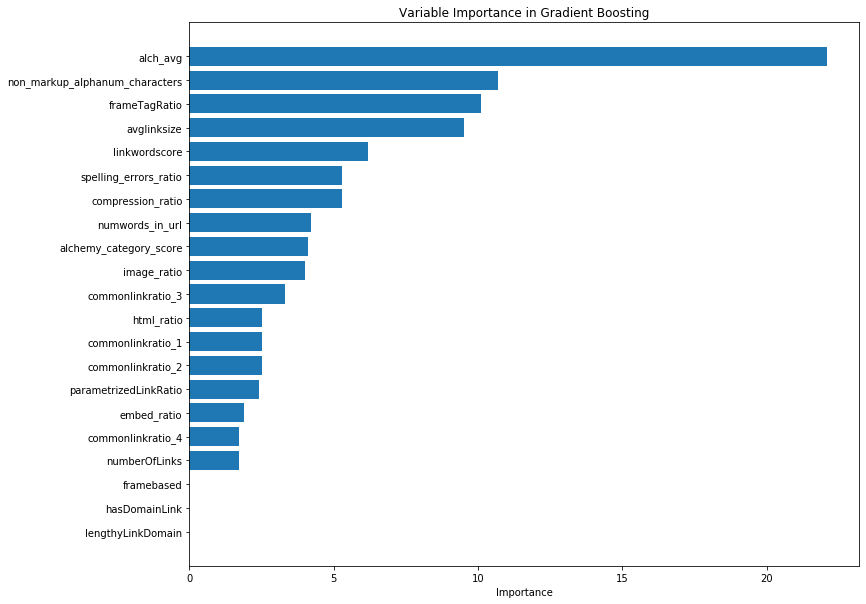

In [45]:
# bar graph to show feature importance
gbm_feat_imp = gbm_feat_imp.sort_values(by= ["imp"], ascending= True)
pos = np.arange(gbm_feat_imp.shape[0]) + 0.5
plt.figure(figsize=(12, 10))
plt.subplot(1, 1, 1)
plt.barh(pos, gbm_feat_imp.imp.values*100, align='center')
plt.yticks(pos, gbm_feat_imp.feat.values)
plt.xlabel("Importance")
plt.title("Variable Importance in Gradient Boosting")
plt.show()

<Figure size 432x288 with 0 Axes>

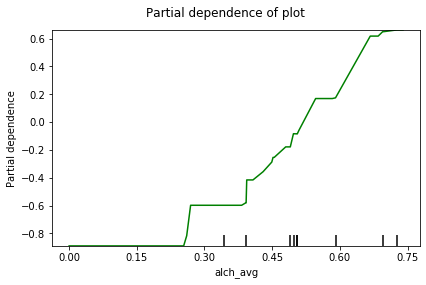

In [46]:
# Partial dependence plots
fig=plt.figure()
fig, axs = plot_partial_dependence(gbm1, train[feat], features= [20], 
                                   feature_names= feat, grid_resolution= 100) 
fig.suptitle('Partial dependence of plot')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle
plt.show();

---

Text processing
=============

In [47]:
# ==========================================
# 5. Feature engineering
# ==========================================


# =============================
# 5.3.1 Text features
# =============================

# simple text mining -- count number of words in each document 
count_dtm = CountVectorizer(min_df= 10,  max_features= 100, strip_accents= 'unicode',
                            analyzer= "word", token_pattern= r"\w{1,}", ngram_range=(1, 2), 
                            binary= True)
count_dtm.fit(train["boilerplate"])

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=100, min_df=10,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents='unicode', token_pattern='\\w{1,}',
                tokenizer=None, vocabulary=None)

In [48]:
# create document term matrix
train_cnt_dtm = count_dtm.transform(train["boilerplate"])
val_cnt_dtm = count_dtm.transform(val["boilerplate"])
test_cnt_dtm = count_dtm.transform(test["boilerplate"])
print(train_cnt_dtm.shape); print(val_cnt_dtm.shape); print(test_cnt_dtm.shape)

(3697, 100)
(1849, 100)
(1849, 100)


---

#### Logistic Regression with Text Processing

In [1]:
# =============================
# 4.6 Logistic with 
#     text features
# =============================

# fit logistic regression
logReg3 = LogisticRegression(penalty = "l2", C = 1)
logReg3.fit(train_cnt_dtm, train["label"])

# predict on validation data
logReg3_val = pd.Series(logReg3.predict(val_cnt_dtm))
print(" -- -- -- ")

# auc score
print("Logistic with text features: " + str(np.round(roc_auc_score(val["label"], logReg3_val.values), 5)))

NameError: name 'LogisticRegression' is not defined

---

#### Text Features

In [50]:
# =============================
# 5.3.2 Text features
# =============================

# TFIDF
idf_dtm = TfidfVectorizer(min_df= 10,  max_features= None, strip_accents= "unicode",
                          analyzer= "word", token_pattern= r"\w{1,}", ngram_range=(1, 2), 
                          use_idf= 1, smooth_idf= 1, sublinear_tf= 1)
idf_dtm.fit(train["boilerplate"])
train_idf_dtm = idf_dtm.transform(train["boilerplate"])
val_idf_dtm = idf_dtm.transform(val["boilerplate"])
test_idf_dtm = idf_dtm.transform(test["boilerplate"])
print(train_idf_dtm.shape); print(val_idf_dtm.shape); print(test_idf_dtm.shape)

(3697, 24432)
(1849, 24432)
(1849, 24432)


---

In [51]:
# =============================
# 4.6 Logistic with 
#     text features
# =============================

# fit logistic regression
logReg4 = LogisticRegression(penalty = "l2", C = 1)
logReg4.fit(train_idf_dtm, train["label"])

# predict on validation data
logReg4_val = pd.Series(logReg4.predict(val_idf_dtm))
print(" -- -- -- ")

# auc score
print("Logistic with text features: " + str(np.round(roc_auc_score(val["label"], logReg4_val.values), 5)))

 -- -- -- 
Logistic with text features: 0.80246


---

Dimension reduction
===========

### Text feature selection using logistic regression

In [52]:
# =============================
# 5.4 Feature selection
# =============================

def textFeatureSelect(dtm, target, model, tf_object, nfolds= 4, nreps= 2):
    feat_imp = pd.DataFrame({"feat":[], "imp": []})
    for r in range(0, nreps):
        print("Run", r+1, "of", nreps)
        folds = createFolds(df= dtm, nfolds= nfolds)
        for f in range(0, nfolds):
            print("Fold", f+1, "of", nfolds)
            tr = np.where(folds.values != f)[0]
            va = np.where(folds.values == f)[0]
            model.fit(dtm[tr,:], target[tr])
            imp = pd.DataFrame({"feat": tf_object.get_feature_names(), "imp": model.coef_[0,:]})
            imp["imp"] = imp["imp"].abs()
            feat_imp = feat_imp.append(imp)

    feat_imp = feat_imp.groupby("feat")
    feat_imp = feat_imp.agg({"imp": np.mean})
    feat_imp = pd.DataFrame({"feat": feat_imp.index, "imp": feat_imp.imp})
    feat_imp = feat_imp.sort_values(by = ["imp"], ascending= False)
    
    return feat_imp

In [53]:
# Select best features from text data using logistic regression
model = LogisticRegression(penalty = "l2", C = 1)
imp_text_feat = textFeatureSelect(train_idf_dtm, target= train["label"].values, model= model, 
                                  tf_object= idf_dtm, nfolds= 4, nreps= 2)

Run 1 of 2
Fold 1 of 4
Fold 2 of 4
Fold 3 of 4
Fold 4 of 4
Run 2 of 2
Fold 1 of 4
Fold 2 of 4
Fold 3 of 4
Fold 4 of 4


In [54]:
# important text features
print(imp_text_feat.head(20))

# keep the top 1000 ones
text_feat = imp_text_feat.iloc[0:1000, :]
idf_dtm_words = pd.DataFrame({"feat": idf_dtm.get_feature_names()})
idf_dtm_words = pd.merge(idf_dtm_words, text_feat, on= "feat", how= "inner", left_index= False, right_index= True)

# subset dtm with important features only
train_idf_dtm_sub = train_idf_dtm[:, idf_dtm_words.index]
val_idf_dtm_sub = val_idf_dtm[:, idf_dtm_words.index]
test_idf_dtm_sub = test_idf_dtm[:, idf_dtm_words.index]
print(" --- ")
print(train_idf_dtm_sub.shape); print(val_idf_dtm_sub.shape); print(val_idf_dtm_sub.shape)

                  feat       imp
feat                            
recipe          recipe  2.876146
recipes        recipes  2.598850
news              news  1.978249
fashion        fashion  1.783520
food              food  1.454226
cheese          cheese  1.312853
make              make  1.311854
video            video  1.311620
chicken        chicken  1.307799
chocolate    chocolate  1.284137
1                    1  1.277455
butter          butter  1.261568
baking          baking  1.192999
cooking        cooking  1.174404
allrecipes  allrecipes  1.129374
cup                cup  1.122985
minutes        minutes  1.111052
until            until  1.103590
s                    s  1.096590
cook              cook  1.051645
 --- 
(3697, 1000)
(1849, 1000)
(1849, 1000)


---

In [55]:
# =============================
# 4.7 Logistic with important
#     text features
# =============================

# fit logistic regression
logReg5 = LogisticRegression(penalty = "l2", C = 1)
logReg5.fit(train_idf_dtm_sub, train["label"])

# predict on validation data
logReg5_val = pd.Series(logReg5.predict_proba(val_idf_dtm_sub)[:,1])
print(" -- -- -- ")

# auc score
print("Logistic with text features: " + str(np.round(roc_auc_score(val["label"], logReg5_val.values), 5)))

 -- -- -- 
Logistic with text features: 0.86599


----

# Class Exercise

### Build logistic regression model with different values of the penalty parameter. What do you find?

In [56]:
# =============================
# Class Exercise - varying penalty
# =============================

### Enter code here

---

Variance explained (first 10 components): 6.69


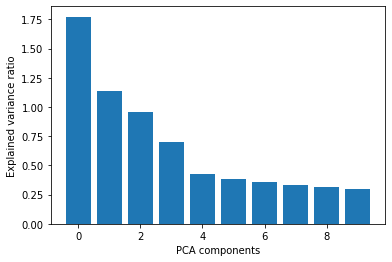

In [57]:
# =============================
# 5.5 Dimension reduction -- PCA
# =============================

# 5.5.1 Sample fit

# Sample fit with 10 components
rpca = PCA(n_components = 10, random_state = 8795, svd_solver = "randomized")
rpca.fit(train_idf_dtm.toarray())
print ('Variance explained (first %d components): %.2f'%(10, sum(rpca.explained_variance_ratio_)*100))

# plot
exp_var = list((rpca.explained_variance_ratio_)*100)
x = range(10)
plt.bar(x, exp_var)
plt.xlabel("PCA components")
plt.ylabel("Explained variance ratio")
plt.show()

In [58]:
# fit with 100 components
rpca = PCA(n_components = 100, random_state = 8795, svd_solver = "randomized")
rpca.fit(train_idf_dtm.toarray())

# tranform dtm
train_idf_dtm_pca = rpca.transform(train_idf_dtm.toarray())
val_idf_dtm_pca = rpca.transform(val_idf_dtm.toarray())
test_idf_dtm_pca = rpca.transform(test_idf_dtm.toarray())
print(" --- ")
print(train_idf_dtm_pca.shape); print(val_idf_dtm_pca.shape); print(test_idf_dtm_pca.shape)

 --- 
(3697, 100)
(1849, 100)
(1849, 100)


In [59]:
# =============================
# 5.5 Dimension reduction
# =============================

# 5.5.2 Optimizing number of components

def pca_optimization(n_comp, train, val, training_target, validation_target, 
                     model, evaluation, classify=True):
    output = pd.DataFrame(columns=['n_comp', 'score'])

    for r in range(0,len(n_comp)):
        rpca = PCA(n_components = n_comp[r], random_state = 8756, svd_solver = "randomized") 
        rpca.fit(train.toarray())
    
        # tranform dtm
        train_pca = rpca.transform(train.toarray())
        val_pca = rpca.transform(val.toarray())
        print(" --- ")
        print('explained variance (first %d components): %.2f'%(n_comp[r], sum(rpca.explained_variance_ratio_)))

        if classify:   
            model.fit(train_pca, training_target)
            model_val = pd.Series(model.predict_proba(val_pca)[:,1])
        else:
            model.fit(train_pca, training_target)
            model_val = pd.Series(model.predict(val_pca))
        score = np.round(evaluation(validation_target, model_val.values), 5)
        data= {"id": n_comp[r],"score": score}
        output = output.append(pd.Series([n_comp[r], score], index=['n_comp','score']), ignore_index=True)
        
    return output

In [60]:
# optimal number of pca components
model = LogisticRegression(penalty = "l2", C = 1)
pca_optimization(n_comp= [50, 100, 200], train= train_idf_dtm, val= val_idf_dtm, 
                 training_target= train["label"], validation_target= val["label"], model= model, 
                 evaluation= roc_auc_score, classify= True)


 --- 
explained variance (first 50 components): 0.13
 --- 
explained variance (first 100 components): 0.18
 --- 
explained variance (first 200 components): 0.25


,n_comp,score
0,50.0,0.86715
1,100.0,0.86917
2,200.0,0.86878


---

In [61]:
# =============================
# 4.7 Logistic with PCA
# =============================

# fit logistic regression
logReg6 = LogisticRegression(penalty = "l2", C = 1)
logReg6.fit(train_idf_dtm_pca, train["label"])

# predict on validation data
logReg6_val = pd.Series(logReg6.predict_proba(val_idf_dtm_pca)[:,1])
print(" -- -- -- ")

# auc score
print("Logistic with text features: " + str(np.round(roc_auc_score(val["label"], logReg6_val.values), 5)))

 -- -- -- 
Logistic with text features: 0.86865


In [62]:
# =============================
# 4.8 Gradient Boosting with PCA
# =============================

# simple gbm
gbm2 = GradientBoostingClassifier(loss = "deviance", learning_rate= 0.1, n_estimators= 100,
                                 max_depth= 2, min_samples_split= 10, min_samples_leaf= 10,
                                 subsample= 0.5, max_features= None, verbose= 0)
gbm2.fit(train_idf_dtm_pca, train["label"])

# predict on validation data
gbm2_val = pd.Series(gbm2.predict_proba(val_idf_dtm_pca)[:,1])
print(" -- -- -- ")

# auc score
print("GBM: " + str(np.round(roc_auc_score(val["label"], gbm2_val.values), 5)))

 -- -- -- 
GBM: 0.86781


-----

## Quick Ensemble

In [63]:
# simple blend of logistic and GBM
simple_avg_val = np.mean([logReg5_val.values, gbm2_val.values], axis= 0)
print("Simple Avg:" + str(roc_auc_score(val["label"], simple_avg_val)))

Simple Avg:0.8700866311436857


-----

## Random Forests

In [64]:
# =============================
# 4.9 Random Forest with PCA
#     and meta features
# =============================

# join meta features with pca features
feat = ["avglinksize", "commonlinkratio_1", "commonlinkratio_2", "commonlinkratio_3", "commonlinkratio_4", 
        "compression_ratio", "embed_ratio", "framebased", "frameTagRatio", "hasDomainLink", "html_ratio",
        "image_ratio", "lengthyLinkDomain", "linkwordscore", "non_markup_alphanum_characters", "numberOfLinks", 
        "numwords_in_url", "parametrizedLinkRatio","spelling_errors_ratio", "alchemy_category_score", 
        "alch_avg"]
train_combine = train[feat].join(pd.DataFrame(train_idf_dtm_pca, index= train.index))
val_combine = val[feat].join(pd.DataFrame(val_idf_dtm_pca, index= val.index))
test_combine = test[feat].join(pd.DataFrame(test_idf_dtm_pca, index= test.index))

# random forests
rf1 = RandomForestClassifier(n_estimators= 100, random_state= 9876, verbose= 1)
rf1.fit(train_combine, train["label"])

# predict on validation data
rf1_val = pd.Series(rf1.predict_proba(val_combine)[:,1])
print(" -- -- -- ")

# auc score
print("RF: " + str(np.round(roc_auc_score(val["label"], rf1_val.values), 5)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


 -- -- -- 
RF: 0.86784


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [65]:
# simple blend of logistic, GBM, and RF
simple_avg_val = np.mean([logReg5_val.values, gbm2_val.values, rf1_val.values], axis= 0)
print("Simple Avg:" + str(roc_auc_score(val["label"], simple_avg_val)))

Simple Avg:0.8719891465358074


-----

Ensemble learning
========================

In [75]:
# ==========================================
# 7. Ensemble
# ==========================================


# =============================
# 7.1 Ensemble DF
# =============================

# order prediction data sets
train["sort_col"] = range(0, train.shape[0])
gbm4_train = pd.merge(gbm4_train, train[["urlid", "sort_col"]], on= "urlid", how= 'left').sort_values(by= ["sort_col"])
rf2_train = pd.merge(rf2_train, train[["urlid", "sort_col"]], on= "urlid", how= 'left').sort_values(by= ["sort_col"])

In [76]:
# create data frame containing all predictions
train_ens = pd.DataFrame({"urlid": gbm4_train.urlid.values, "label": gbm4_train.target.values, 
                          "logReg7": logReg7_train.pred.values,
                          "gbm4": gbm4_train.pred.values, "rf2": rf2_train.pred.values,
                         "ert1": ert1_train.pred.values})
val_ens = pd.DataFrame({"urlid": gbm4_val.urlid.values, "gbm4": gbm4_val.pred.values,
                        "logReg7": logReg7_val.values, "rf2": rf2_val.pred.values,
                       "ert1": ert1_val.values})
val_ens = pd.merge(val_ens, val[["urlid", "label"]], on= "urlid")

print(train_ens.columns.values); print(val_ens.columns.values)

['ert1' 'gbm4' 'label' 'logReg7' 'rf2' 'urlid']
['ert1' 'gbm4' 'logReg7' 'rf2' 'urlid' 'label']


In [77]:
# =============================
# 7.2 Simple average
# =============================

# simple average
simple_avg_train = np.mean([train_ens.gbm4.values, train_ens.rf2.values, train_ens.logReg7.values,
                           train_ens.ert1.values], axis= 0)
print("Simple avg cv: " + str(np.round(roc_auc_score(train_ens["label"], simple_avg_train), 5)))

simple_avg_val = np.mean([val_ens.gbm4.values, val_ens.rf2.values, val_ens.logReg7.values,
                         val_ens.ert1.values], axis= 0)
print("Simple avg val: " + str(np.round(roc_auc_score(val_ens["label"], simple_avg_val), 5)))

Simple avg cv: 0.87969
Simple avg val: 0.87108


In [78]:
# =============================
# 7.3 Weighted average
# Proportional representation vs. egalitarian democracy
# =============================

# weighted average
weight_avg_train = 0.8*train_ens.gbm4.values + 1.4*train_ens.logReg7.values
print("Weighted avg cv: " + str(np.round(roc_auc_score(train_ens["label"], weight_avg_train), 5)))

weight_avg_val = 0.8*val_ens.gbm4.values + 1.4*val_ens.logReg7.values
print("Weighted avg val: " + str(np.round(roc_auc_score(val_ens["label"], weight_avg_val), 5)))

Weighted avg cv: 0.87617
Weighted avg val: 0.86831


In [79]:
# =============================
# 7.4 Rank average
# =============================

# rank urlids by each prediction vector and then average
def get_ranked_preds(df, feat):
    for f in feat:
        df = df.sort_values(by = [f], ascending= True)
        df[f + "_rank"] = range(1, df.shape[0] + 1)
    return(df)

train_ens_rank = get_ranked_preds(train_ens, ["gbm4", "logReg7", "rf2", "ert1"])
val_ens_rank = get_ranked_preds(val_ens, ["gbm4", "logReg7", "rf2", "ert1"])

# simple average
rank_avg_train = np.mean([train_ens_rank.gbm4_rank.values, train_ens_rank.rf2_rank.values, 
                            train_ens_rank.logReg7_rank.values], axis= 0)
print("Rank avg cv: " + str(np.round(roc_auc_score(train_ens_rank["label"], rank_avg_train), 5)))


rank_avg_val = np.mean([val_ens_rank.gbm4_rank.values, val_ens_rank.rf2_rank.values, 
                            val_ens_rank.logReg7_rank.values], axis= 0)
print("Rank avg val: " + str(np.round(roc_auc_score(val_ens_rank["label"], rank_avg_val), 5)))

Rank avg cv: 0.87653
Rank avg val: 0.87086


In [80]:
# =============================
# 7.5 Stacked generalization
# =============================

# convert probabilities to logits
train_ens.describe()
feat = ["gbm4", "logReg7", "rf2", "ert1"]

train_ens[feat] = train_ens[feat].clip(0.01, 0.99)
val_ens[feat] = val_ens[feat].clip(0.01, 0.99)

train_ens[feat] = train_ens[feat].apply(st.logistic.ppf)
val_ens[feat] = val_ens[feat].apply(st.logistic.ppf)

print(" --- ")
print(train_ens.head())
print(val_ens.head())

 --- 
       ert1      gbm4  label   logReg7       rf2    urlid
0 -1.177639 -1.881652    0.0 -1.820647 -1.835509   8065.0
1  0.225723  0.926770    0.0  0.037044  0.759139   9682.0
2 -0.864059 -0.710574    0.0 -0.463699 -0.650852   6219.0
3 -1.162181 -1.449012    1.0 -0.721405 -1.056638   8312.0
4 -1.252145 -1.724036    0.0 -1.169940 -1.112203  10299.0
       ert1      gbm4   logReg7       rf2  urlid  label
0 -1.919044 -1.842144 -1.342612 -2.731036   3612      0
1 -1.367979 -1.135458 -0.749207 -0.774108   2771      0
2 -2.047119 -2.149053 -1.644974 -2.711849   1272      0
3 -1.595168 -1.222006 -1.336413 -1.142592   3178      1
4  3.038552  2.508206  2.971262  2.350453   1474      1


In [81]:
# Correlation matrix of predictions
feat = ["gbm4", "logReg7", "rf2", "ert1"]
train_ens[feat].corr()

,gbm4,logReg7,rf2,ert1
gbm4,1.000000,0.944085,0.943121,0.938304
logReg7,0.944085,1.000000,0.923919,0.965189
rf2,0.943121,0.923919,1.000000,0.932512
ert1,0.938304,0.965189,0.932512,1.000000


In [82]:
# Individual model scores
print("Logistic: " + str(np.round(roc_auc_score(val_ens["label"], val_ens["logReg7"]), 5)))
print("GBM: "  + str(np.round(roc_auc_score(val_ens["label"], val_ens["gbm4"]), 5)))
print("RF: "  + str(np.round(roc_auc_score(val_ens["label"], val_ens["rf2"]), 5)))
print("ERT: "  + str(np.round(roc_auc_score(val_ens["label"], val_ens["ert1"]), 5)))

Logistic: 0.86512
GBM: 0.86719
RF: 0.86885
ERT: 0.86062


In [83]:
# build cv logistic
logReg8_ens = LogisticRegression()
feat = ["gbm4", "logReg7", "rf2", "ert1"]
logReg8_ens_cv, logReg8_ens_val = cvModel(train_ens, val_ens, target= train_ens["label"], model= logReg8_ens, 
                                          feat= feat, idcol= "urlid", nfolds= 4, nreps= 4, classify= True)

# auc score
print(" --- ")
print("Ensemble cv score: " + str(np.round(roc_auc_score(logReg8_ens_cv.target.values, logReg8_ens_cv.pred.values), 5)))
print("Ensemble val score: " + str(np.round(roc_auc_score(val_ens["label"], logReg8_ens_val.pred.values), 5)))

Run 1 of 4
Fold 1 of 4
Fold 2 of 4
Fold 3 of 4
Fold 4 of 4
Run 2 of 4
Fold 1 of 4
Fold 2 of 4
Fold 3 of 4
Fold 4 of 4
Run 3 of 4
Fold 1 of 4
Fold 2 of 4
Fold 3 of 4
Fold 4 of 4
Run 4 of 4
Fold 1 of 4
Fold 2 of 4
Fold 3 of 4
Fold 4 of 4
 --- 
Ensemble cv score: 0.88134
Ensemble val score: 0.86973


------